# XGBOOST - SCORING

In [1]:
import pandas as pd
from sklearn import metrics
import numpy as np
from datetime import date
from sklearn import preprocessing
import xgboost as xgb
import pickle

### GLOBAL VARIABLES

In [2]:
DATAPATH = 'data/processed/'
SEED = 47
NITER = 100
CV = 5
SCORE = 'roc_auc'
handlingnull = False
NJOBS = 2
USEGPU = False
NCLASS = 0

### LOAD DATASET

In [3]:
# Load submission Data
submission = pd.read_pickle(DATAPATH+'submission.pkl')

In [4]:
submission.shape

(178685, 1205)

In [5]:
campaign = pd.read_pickle('data/features/campaign_quarter_001.pkl')

In [6]:
digital = pd.read_pickle('data/features/digital_features_period_001.pkl')

In [7]:
rcc = pd.read_pickle('data/features/submit_rcc_features_ten_001.pkl')

In [8]:
rcc.drop(['id_persona', 'codmes'], inplace=True, axis=1)

In [9]:
submission = submission.join(campaign).join(rcc).join(digital)

In [10]:
submission.shape

(178685, 1770)

In [11]:
### create a DMatrix and handling Null values
if handlingnull:
    #train_features[np.isnan(train_features)] = -9999
    xgsubmit = xgb.DMatrix(submission.values, submission.values, missing=-9999)
else:
    xgsubmit = xgb.DMatrix(submission.values, submission.values)

### LOAD MODEL

In [12]:
# init model
if USEGPU:
    xgb_model = xgb.Booster({'nthread': 4, 'tree_method':'gpu_hist', 'gpu_id':0})
else:
    xgb_model = xgb.Booster({'nthread': 4})  
    
xgb_model.load_model('models/xgb_002.model')  # load data

### SCORING

In [13]:
y_pred = xgb_model.predict(xgsubmit)

In [14]:
cutoff = 0.47768695

### SUBMIT

In [15]:
submit = submission.reset_index()

In [16]:
submit = submit[['prediction_id']]

In [17]:
submit['prediction'] = y_pred

In [18]:
submit['class'] = np.where(submit['prediction'] >= cutoff, 1, 0)

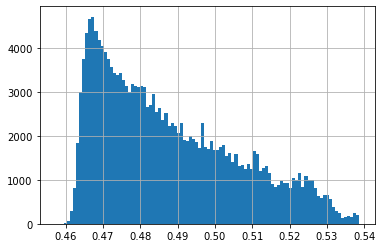

In [21]:
submit['prediction'].hist(bins=100)
pass

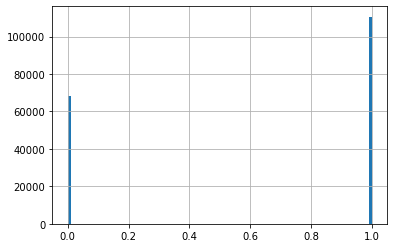

In [20]:
submit['class'].hist(bins=100)
pass

In [22]:
submit.sort_values('prediction_id', ascending=True, inplace=True)

In [23]:
submit.head()

,prediction_id,prediction,class
109924,100000_201905,0.462803,0
143952,100001_201906,0.472088,0
147064,100002_201905,0.492068,1
22567,100005_201905,0.468049,0
78678,100005_201906,0.477190,0


In [39]:
submit = submit[['prediction_id', 'class']].sort_values(by='prediction_id')
submit.to_csv("submits/submit_005.csv", index=False, header=True)